# IMDB Review with NLP

## Problem Statement:

Problem statement - Build multiple machine learning models and select best one for sentiment analysis. Based on user comment your model should be able to predict if the movie is worth to watch or not.

## Importing the required libraries:

In [465]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from bs4 import BeautifulSoup

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
import re
import string
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

import gensim
from gensim import corpora
from pprint import pprint
from gensim.utils import simple_preprocess
import os


## Loading the dataset:

In [466]:
#dataset 1
df1 = pd.read_csv('IMDB-Dataset 1.csv')
df1.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [467]:
df1.shape

(24999, 2)

In [468]:
#dataset 2
df2 = pd.read_csv('IMDB-Dataset2.csv',names=['review','sentiment'])
df2.tail()

,review,sentiment
24996,I thought this movie did a down right good job...,positive
24997,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
24998,I am a Catholic taught in parochial elementary...,negative
24999,I'm going to have to disagree with the previou...,negative
25000,No one expects the Star Trek movies to be high...,negative


In [469]:
df2.shape

(25001, 2)

In [470]:
#combining the two datsets
df = pd.concat([df1,df2],axis=0,ignore_index= True)

In [471]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [472]:
df.shape

(50000, 2)

In [473]:
#lets check for null values in this datset
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [474]:
#we have 50,000 reviews and 49,582 unique reviews
df.review.describe()

count                                                 50000
unique                                                49582
top       Loved today's show!!! It was a variety and not...
freq                                                      5
Name: review, dtype: object

In [475]:
#WE can see that there are no null values in this dataset

In [476]:
#lets check for class imbalance problem
df.sentiment.value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

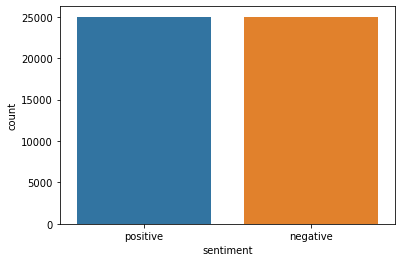

In [477]:
#count plot
sns.countplot(df.sentiment)
plt.show()

We can see that there no class imbalance problem in this dataset, we have 25,000 positive reviews and 25,000 negative reviews

## Data Preprocessing

In [478]:
stopset =set(stopwords.words('english')+['i','u','ur','4','2','im','dont','doin','ure'])
len(stopset)

187

In [479]:
punc = set(string.punctuation + '‘’,:”][]``')
print(punc)
print(len(punc))

{'-', '>', '#', '=', '$', ';', '<', '}', "'", '|', '%', '^', '‘', '?', '&', '/', '!', '[', '\\', '`', ')', '(', '.', '{', '*', ',', ']', '’', ':', '~', '_', '@', '”', '+', '"'}
35


In [480]:
df.review.head()

0    One of the other reviewers has mentioned that ...
1    A wonderful little production. <br /><br />The...
2    I thought this was a wonderful way to spend ti...
3    Basically there's a family where a little boy ...
4    Petter Mattei's "Love in the Time of Money" is...
Name: review, dtype: object

In [481]:
df['Lenght'] = df.review.str.len()

In [482]:
df.head()

,review,sentiment,Lenght
0,One of the other reviewers has mentioned that ...,positive,1761
1,A wonderful little production. <br /><br />The...,positive,998
2,I thought this was a wonderful way to spend ti...,positive,926
3,Basically there's a family where a little boy ...,negative,748
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317


In [483]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [484]:
def cleaning(text):
    text = text.lower()
    
    #Removing the html strips
    text = strip_html(text)
    
    #removing stopwords and punctuations
    text = " ".join([word for word in word_tokenize(text) if word not in stop_words if word not in punc])
    
    #alpha numeric words
    text=re.sub('\w*\d\w*','',text)
    
    text=re.sub('\[.*?\]','',text)
    
    #ectra punctiations
    text=re.sub('[''"",,,]','',text)
    
    #removing \n
    text=re.sub('\n','',text)
    
    #replacing numbers
    text = re.sub(r'\[[0-9]*\]', ' ',text)
    
    #replacing single characters
    text = re.sub(r'\s[A-Za-z0-9]\s','',text)
    
    #replacing single digits
    text = re.sub(r'\d+',' ',text)
    
    #replacing other charcters with space
    text = re.sub(r'[^a-zA-z0-9\s]+',' ',text)
    
    #replacing more than one white spaces
    text = re.sub(r'\s+',' ',text)
    
    return text

In [485]:
cleaned = lambda x : cleaning(x)

In [486]:
df['cleaned_review'] = df.review.apply(cleaned)

In [487]:
df.head()

,review,sentiment,Lenght,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,1761,one reviewers mentioned watching oz episode ll...
1,A wonderful little production. <br /><br />The...,positive,998,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,926,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,748,basically s family little boy jake thinks s zo...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317,petter mattei s `` love time money visually st...


## Lemmatization

In [488]:
from nltk.stem import WordNetLemmatizer,PorterStemmer


In [489]:
lemma = WordNetLemmatizer()
porter = PorterStemmer()

In [490]:
def lemmatize(text):
    text = text.lower()
    text = " ".join([lemma.lemmatize(word,pos='v') for word in word_tokenize(text) if word not in punc])
    #text = " ".join([lemma.lemmatize(word) for word in word_tokenize(text) if word not in punc])
    return text

In [491]:
df['cleaned_review'] = df.cleaned_review.apply(lambda x : lemmatize(x))
df.head()

,review,sentiment,Lenght,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,1761,one reviewers mention watch oz episode ll hook...
1,A wonderful little production. <br /><br />The...,positive,998,wonderful little production film technique una...
2,I thought this was a wonderful way to spend ti...,positive,926,think wonderful way spend time hot summer week...
3,Basically there's a family where a little boy ...,negative,748,basically s family little boy jake think s zom...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317,petter mattei s `` love time money visually st...


In [492]:
df['cleaned Lenght'] = df.cleaned_review.str.len()
df.head()

,review,sentiment,Lenght,cleaned_review,cleaned Lenght
0,One of the other reviewers has mentioned that ...,positive,1761,one reviewers mention watch oz episode ll hook...,1095
1,A wonderful little production. <br /><br />The...,positive,998,wonderful little production film technique una...,630
2,I thought this was a wonderful way to spend ti...,positive,926,think wonderful way spend time hot summer week...,566
3,Basically there's a family where a little boy ...,negative,748,basically s family little boy jake think s zom...,421
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317,petter mattei s `` love time money visually st...,847


In [532]:
df.cleaned_review =df.cleaned_review.str.replace(r'\s+\w\s+',' ')
df.cleaned_review =df.cleaned_review.str.replace(r'\s+',' ')

In [533]:
#label encoding the object columns
df.sentiment = label.fit_transform(df.sentiment)
df.sentiment.head()

0    1
1    1
2    1
3    0
4    1
Name: sentiment, dtype: int64

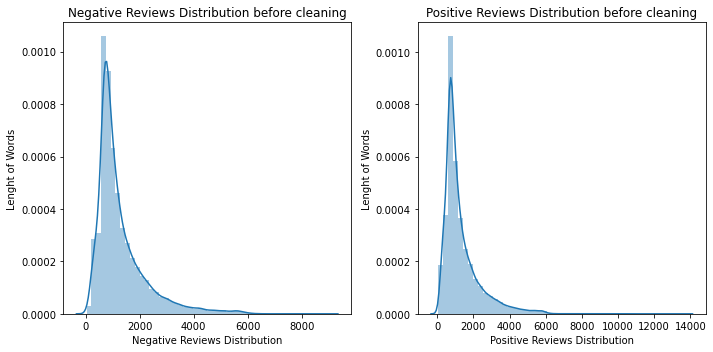

In [534]:
#Reviews distibution before cleaning
labels = ['Negative Reviews Distribution','Positive Reviews Distribution']
plt.figure(figsize= (10,5))
for i in range(len(labels)):
    plt.subplot(1,2,i+1)
    sns.distplot(df[df['sentiment']==i]['Lenght'])
    plt.title(labels[i]+" before cleaning")
    plt.xlabel(labels[i])
    plt.ylabel('Lenght of Words')
    plt.tight_layout()

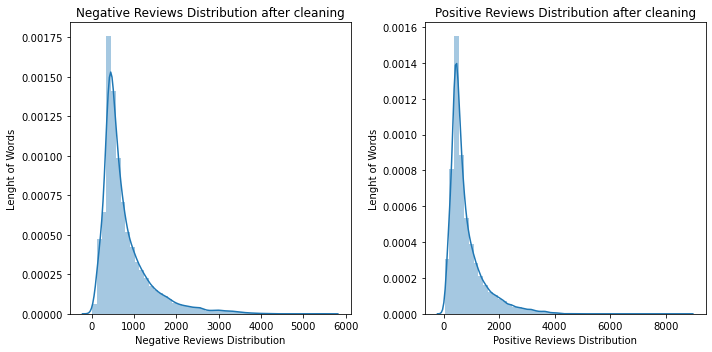

In [535]:
#Reviews distibution before cleaning
labels = ['Negative Reviews Distribution','Positive Reviews Distribution']
plt.figure(figsize= (10,5))
for i in range(len(labels)):
    plt.subplot(1,2,i+1)
    sns.distplot(df[df['sentiment']==i]['cleaned Lenght'])
    plt.title(labels[i]+" after cleaning")
    plt.xlabel(labels[i])
    plt.ylabel('Lenght of Words')
    plt.tight_layout()

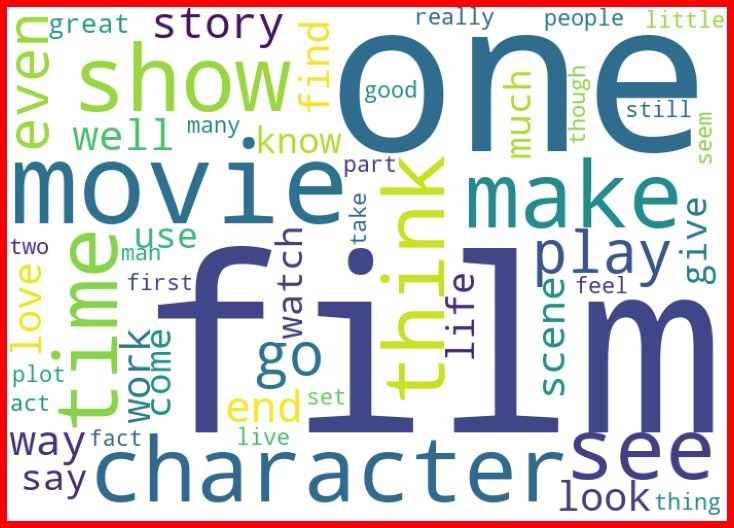

In [540]:
#wordcloud of positive reviews
from wordcloud import WordCloud

positive_reviews = df['cleaned_review'][df['sentiment'] == 1]
positive_reviews_cloud = WordCloud(width=700,height=500,background_color='white',max_words=50).generate(' '.join(positive_reviews))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(positive_reviews_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

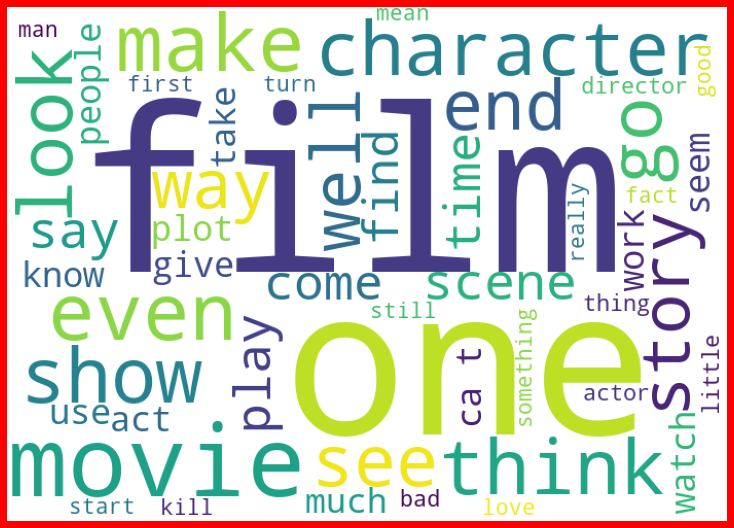

In [541]:
#wordcloud of Negative reviews
from wordcloud import WordCloud
Negative_reviews = df['cleaned_review'][df['sentiment'] == 0]
Negative_reviews_cloud = WordCloud(width=700,height=500,background_color='white',max_words=50).generate(' '.join(Negative_reviews))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(Negative_reviews_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Model Building

In [544]:
from gensim.models import Word2Vec
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
tf_vec =TfidfVectorizer()
naive = MultinomialNB()
label = LabelEncoder()
lr = LogisticRegression()

In [442]:
#count vectorizer
count_vec = CountVectorizer()
count_vec_features = count_vec.fit_transform(df.cleaned_review)

In [645]:
#tfidf
tf_vec =TfidfVectorizer()
tf_features = tf_vec.fit_transform(df.cleaned_review)

In [448]:
#shape of array
count_vec_features.shape

(50000, 91048)

In [450]:
#shape of array
tf_features.shape

(50000, 91048)

### Naive Bayes Model

In [461]:
#naive bayes model with count vectorizer features
X= count_vec_features
Y = df.sentiment

x_train,x_test,y_train,y_test = train_test_split(X,Y,random_state=42,stratify=Y)

naive.fit(x_train,y_train)

y_pred = naive.predict(x_test)

print("Final Score = > ",accuracy_score(y_test,y_pred))
print("\n",classification_report(y_test,y_pred))

Final Score = >  0.86024

               precision    recall  f1-score   support

           0       0.85      0.88      0.86      6250
           1       0.88      0.84      0.86      6250

    accuracy                           0.86     12500
   macro avg       0.86      0.86      0.86     12500
weighted avg       0.86      0.86      0.86     12500



In [462]:
#naive bayes model with Tfidf features
X= tf_features
Y = df.sentiment

x_train,x_test,y_train,y_test = train_test_split(X,Y,random_state=42,stratify=Y)

naive.fit(x_train,y_train)

y_pred = naive.predict(x_test)

print("Final Score = > ",accuracy_score(y_test,y_pred))
print("\n",classification_report(y_test,y_pred))

Final Score = >  0.86376

               precision    recall  f1-score   support

           0       0.85      0.88      0.87      6250
           1       0.87      0.85      0.86      6250

    accuracy                           0.86     12500
   macro avg       0.86      0.86      0.86     12500
weighted avg       0.86      0.86      0.86     12500



### Logistic regression Model

In [546]:
#Logistice regression model with count vectorizer features
X= count_vec_features
Y = df.sentiment

x_train,x_test,y_train,y_test = train_test_split(X,Y,random_state=42,stratify=Y)

lr.fit(x_train,y_train)

y_pred = lr.predict(x_test)

print("Final Score of logistic regression= > ",accuracy_score(y_test,y_pred))
print("\n",classification_report(y_test,y_pred))

Final Score of logistic regression= >  0.88504

               precision    recall  f1-score   support

           0       0.89      0.88      0.88      6250
           1       0.88      0.89      0.89      6250

    accuracy                           0.89     12500
   macro avg       0.89      0.89      0.89     12500
weighted avg       0.89      0.89      0.89     12500



In [547]:
#Logistice regression model with tfidf vectorizer features
X= tf_features
Y = df.sentiment

x_train,x_test,y_train,y_test = train_test_split(X,Y,random_state=42,stratify=Y)

lr.fit(x_train,y_train)

y_pred = lr.predict(x_test)

print("Final Score of logistic regression= > ",accuracy_score(y_test,y_pred))
print("\n",classification_report(y_test,y_pred))

Final Score of logistic regression= >  0.896

               precision    recall  f1-score   support

           0       0.91      0.88      0.89      6250
           1       0.89      0.91      0.90      6250

    accuracy                           0.90     12500
   macro avg       0.90      0.90      0.90     12500
weighted avg       0.90      0.90      0.90     12500



In [574]:
#our accuracy score is increced to 90% using Logistic regression model

## Fuction to check Review using count vectorizer and Logistic regression

In [649]:
#Function to Check if a if review is negative or postive
def check_review():
    review = input("Please enter your Review based on the Movie: \n")
    passing_list = ["Null"]
    passing_list[0] = review    
    review_fetures = count_vec.transform(passing_list)
    test = review_fetures.toarray()
    result = lr.predict(test)
    if result[0] == 0:
        return "Negative Review"
    else:
        return "Positve Review"
check_review()


Please enter your Review based on the Movie: 
s


'Positve Review'

## Fuction to check Review using TF-IDF vectorizer and Logistic regression

In [661]:
#Function to Check if a if review is negative or postive
def check_review():
    review = input("Please enter your Review based on the Movie: \n\n")
    passing_list = ["Null"]
    passing_list[0] = review    
    review_fetures = tf_vec.transform(passing_list)
    test = review_fetures.toarray()
    result = lr.predict(test)
    if result[0] == 0:
        return "Negative Review"
    else:
        return "Positve Review"
check_review()


Please enter your Review based on the Movie: 

Petter Mattei\'s "Love in the Time of Money" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. <br /><br />This being a variation on the Arthur Schnitzler\'s play about the same theme, the director transfers the action to the present time New York where all these different characters meet and connect. Each one is connected in one way, or another to the next person, but no one seems to know the previous point of contact. Stylishly, the film has a sophisticated luxurious look. We are taken to see how these people live and the world they live in their own habitat.<br /><br />The only thing one gets out of all these souls in the picture is the different stages of loneliness each one inhabits. A big city is not exactly the best place in which human relations find sincer

'Positve Review'